In [2]:
import json
import pandas as pd
import requests
from tqdm import tqdm
from upsetplot import plot
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import kaleido

## Initial Import & Normalization
Import the json data from v1, structure it in a dataframe, and then use the VICC normalizers to normalize the data. This will likely only be run once and analysis work can just load a pre-run excel.

In [55]:
files = ['brca.vr.json',
         'cgi.vr.json',
         'civic.vr.json',
         'jax.vr.json',
         'molecularmatch.vr.json',
         'oncokb.vr.json',
         'pmkb.vr.json']

In [ ]:
def load_v1_data(data,source_name):
    extracted_data = []
    for item in data:
        try: # TODO: Handle KeyError [0] in phenotype_term for molecularmatch
            extracted_data.append({
                'genes': item.get('genes', None),
                'feature_names': item.get('feature_names', None),
                'drug_labels': item.get('association', {}).get('drug_labels', None),
                'variant_name': item.get('association', {}).get('variant_name', None),
                'phenotype_term': item.get('association', {}).get('phenotypes', {})[0].get('term',None), # TODO: Check for >1 entries
                'source': f'{source_name.split(".")[0]}'
            })
        except:
            pass
    df = pd.DataFrame(extracted_data)

    return(df)

In [56]:
v1_data = pd.DataFrame()

for file in tqdm(files):
    with open(f'v1_data/{file}','r') as f:
        data = []
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                pass
        # tdf = load_v1_data(data,file)
        # v1_data = pd.concat([v1_data,tdf]).reset_index(drop=True)

# v1_data

100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


In [68]:
# data[0]['features'][0]['geneSymbol']
data[0]['genes']

['CSF3R']

In [36]:
# Expand the rows with multiple genes into separate rows
expanded_rows = []
for index, row in v1_data.iterrows():
    for gene in row['genes']:
        new_row = row.copy()
        new_row['genes'] = gene
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows list
v1_data = pd.DataFrame(expanded_rows).reset_index(drop=True)
v1_data

,genes,feature_names,drug_labels,variant_name,phenotype_term,source,gene,therapy_concept_id,gene_concept_id
0,BRCA1,?,None,None,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100
1,BRCA1,E1038G,None,None,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100
2,BRCA1,?,None,None,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100
3,BRCA1,E1250K,None,None,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100
4,BRCA1,?,None,None,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100
...,...,...,...,...,...,...,...,...,...
32275,PATZ1,PATZ1 any mutation,NA,None,acinar cell carcinoma,pmkb,PATZ1,None,None
32276,ZNF331,ZNF331 any mutation,NA,None,acinar cell carcinoma,pmkb,ZNF331,None,None
32277,ZNF384,ZNF384 any mutation,NA,None,acinar cell carcinoma,pmkb,ZNF384,None,None
32278,ZNF521,ZNF521 any mutation,NA,None,acinar cell carcinoma,pmkb,ZNF521,None,None


In [31]:
def normalize_gene(gene):
    url = f'https://normalize.cancervariants.org/gene/normalize?q={gene}'
    r = requests.get(url)
    if r.json()['match_type'] == 0:
        concept_id = 'No Match'
    else:
        concept_id = r.json()['gene']['id']
    return concept_id

def normalize_disease(disease):
    url = f'https://normalize.cancervariants.org/disease/normalize?q={disease}'
    r = requests.get(url)
    if r.json()['match_type'] == 0:
        concept_id = 'No Match'
    else:
        concept_id = r.json()['disease']['id']
    return concept_id

def normalize_therapy(therapy):
    url = f'https://normalize.cancervariants.org/therapy/normalize?q={therapy}'
    r = requests.get(url)
    if r.json()['match_type'] == 0:
        concept_id = 'No Match'
    else:
        concept_id = r.json()['therapy']['id']
    return concept_id

In [37]:
# Normalize Genes
v1_data['gene_concept_id'] = None
for idx, row in tqdm(v1_data.iterrows()):
    gene = v1_data.at[idx,'genes']
    v1_data.at[idx, 'gene_concept_id'] = normalize_gene(gene)

32280it [50:30, 10.65it/s]


In [38]:
# Normalize Disease
v1_data['disease_concept_id'] = None
for idx, row in tqdm(v1_data.iterrows()):
    disease = v1_data.at[idx,'phenotype_term']
    v1_data.at[idx, 'disease_concept_id'] = normalize_disease(disease)

32280it [47:56, 11.22it/s]


In [39]:
# Normalize Therapy
v1_data['therapy_concept_id'] = None
for idx, row in tqdm(v1_data.iterrows()):
    therapy = v1_data.at[idx,'drug_labels']
    v1_data.at[idx, 'therapy_concept_id'] = normalize_therapy(therapy)

32280it [52:56, 10.16it/s]


## Analysis
Load already normalized v1 data (run in the above section) and perform analysis work for uniqueness, normalization, and duplicity.

In [46]:
df = pd.read_excel('v1_data_normalized.xlsx').drop(labels='Unnamed: 0',axis=1)
df

,genes,feature_names,drug_labels,variant_name,phenotype_term,source,gene,therapy_concept_id,gene_concept_id,disease_concept_id
0,BRCA1,?,NaN,NaN,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100,normalize.disease.ncit:C9335
1,BRCA1,E1038G,NaN,NaN,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100,normalize.disease.ncit:C9335
2,BRCA1,?,NaN,NaN,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100,normalize.disease.ncit:C9335
3,BRCA1,E1250K,NaN,NaN,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100,normalize.disease.ncit:C9335
4,BRCA1,?,NaN,NaN,breast cancer,brca,BRCA1,No Match,normalize.gene.hgnc:1100,normalize.disease.ncit:C9335
...,...,...,...,...,...,...,...,...,...,...
32275,PATZ1,PATZ1 any mutation,NaN,NaN,acinar cell carcinoma,pmkb,PATZ1,normalize.therapy.rxcui:476250,normalize.gene.hgnc:13071,normalize.disease.ncit:C3768
32276,ZNF331,ZNF331 any mutation,NaN,NaN,acinar cell carcinoma,pmkb,ZNF331,normalize.therapy.rxcui:476250,normalize.gene.hgnc:15489,normalize.disease.ncit:C3768
32277,ZNF384,ZNF384 any mutation,NaN,NaN,acinar cell carcinoma,pmkb,ZNF384,normalize.therapy.rxcui:476250,normalize.gene.hgnc:11955,normalize.disease.ncit:C3768
32278,ZNF521,ZNF521 any mutation,NaN,NaN,acinar cell carcinoma,pmkb,ZNF521,normalize.therapy.rxcui:476250,normalize.gene.hgnc:24605,normalize.disease.ncit:C3768


In [47]:
def calculate_uniqueness(test_df,reference_df,column_prefix):
    sources = list(reference_df['source'].unique())
    for idx, row in tqdm(test_df.iterrows()):
        current_value = test_df.at[idx,f'{column_prefix}s']
        for source in sources:
            tdf = reference_df[reference_df['source']==source]
            if current_value in list(tdf[f'{column_prefix}_id'].unique()):
                test_df.at[idx,source] = True
            elif current_value not in list(tdf[f'{column_prefix}_id'].unique()):
                test_df.at[idx,source] = False
            else:
                test_df.at[idx,source] = 'Something went wrong'       
            pass
        pass
    return(test_df)

def format_for_upset(test_df,column_prefix):
    test_df.set_index(f'{column_prefix}s', inplace=True)
    for col in test_df:
        test_df[col] = test_df[col].astype(bool)
    upset_data = test_df.groupby(list(test_df.columns)).size()
    return(upset_data)


# Initialize unique groups for identifying uniqueness
unique_gene_concepts = list(df['gene_concept_id'].unique())
unique_therapy_concepts = list(df['therapy_concept_id'].unique())
unique_disease_concepts = list(df['disease_concept_id'].unique())

### Genes

In [48]:
gene_uniqueness = pd.DataFrame({'gene_concepts': unique_gene_concepts,
                                'brca': None,
                                'cgi': None,
                                'civic': None,
                                'jax': None,
                                'molecularmatch': None,
                                'oncokb': None,
                                'pmkb': None})
gene_uniqueness

,gene_concepts,brca,cgi,civic,jax,molecularmatch,oncokb,pmkb
0,normalize.gene.hgnc:1100,None,None,None,None,None,None,None
1,normalize.gene.hgnc:1101,None,None,None,None,None,None,None
2,normalize.gene.hgnc:76,None,None,None,None,None,None,None
3,normalize.gene.hgnc:391,None,None,None,None,None,None,None
4,normalize.gene.hgnc:392,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
917,normalize.gene.hgnc:12989,None,None,None,None,None,None,None
918,normalize.gene.hgnc:13071,None,None,None,None,None,None,None
919,normalize.gene.hgnc:15489,None,None,None,None,None,None,None
920,normalize.gene.hgnc:11955,None,None,None,None,None,None,None


922it [00:08, 105.05it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

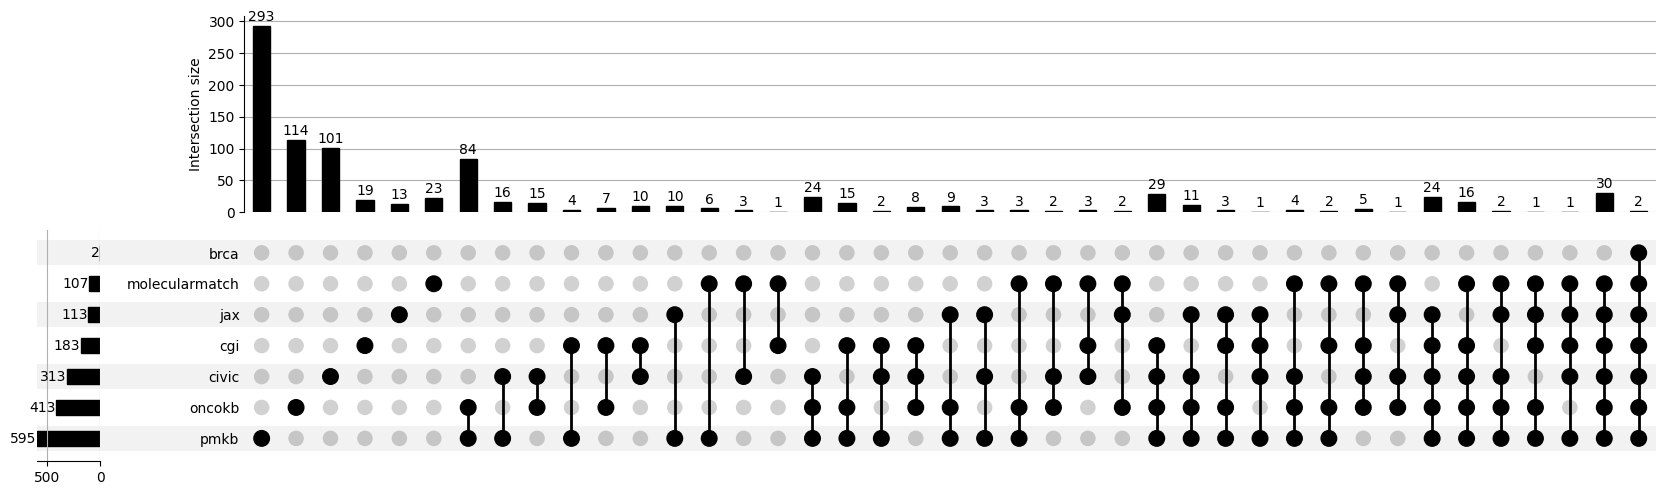

In [49]:
gene_uniqueness = calculate_uniqueness(gene_uniqueness,df,'gene_concept')
gene_proportions = gene_uniqueness # Copy of the DF for later
upset_data = format_for_upset(gene_uniqueness,'gene_concept')
plot(upset_data, show_counts=True)
plt.savefig('gene_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### Diseases

In [50]:
disease_uniqueness = pd.DataFrame({'disease_concepts': unique_disease_concepts,
                                'brca': None,
                                'cgi': None,
                                'civic': None,
                                'jax': None,
                                'molecularmatch': None,
                                'oncokb': None,
                                'pmkb': None})
disease_uniqueness

,disease_concepts,brca,cgi,civic,jax,molecularmatch,oncokb,pmkb
0,normalize.disease.ncit:C9335,None,None,None,None,None,None,None
1,normalize.disease.ncit:C3174,None,None,None,None,None,None,None
2,normalize.disease.ncit:C9305,None,None,None,None,None,None,None
3,No Match,None,None,None,None,None,None,None
4,normalize.disease.ncit:C27815,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
326,normalize.disease.ncit:C2964,None,None,None,None,None,None,None
327,normalize.disease.ncit:C9474,None,None,None,None,None,None,None
328,normalize.disease.ncit:C4017,None,None,None,None,None,None,None
329,normalize.disease.ncit:C4862,None,None,None,None,None,None,None


331it [00:03, 107.90it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

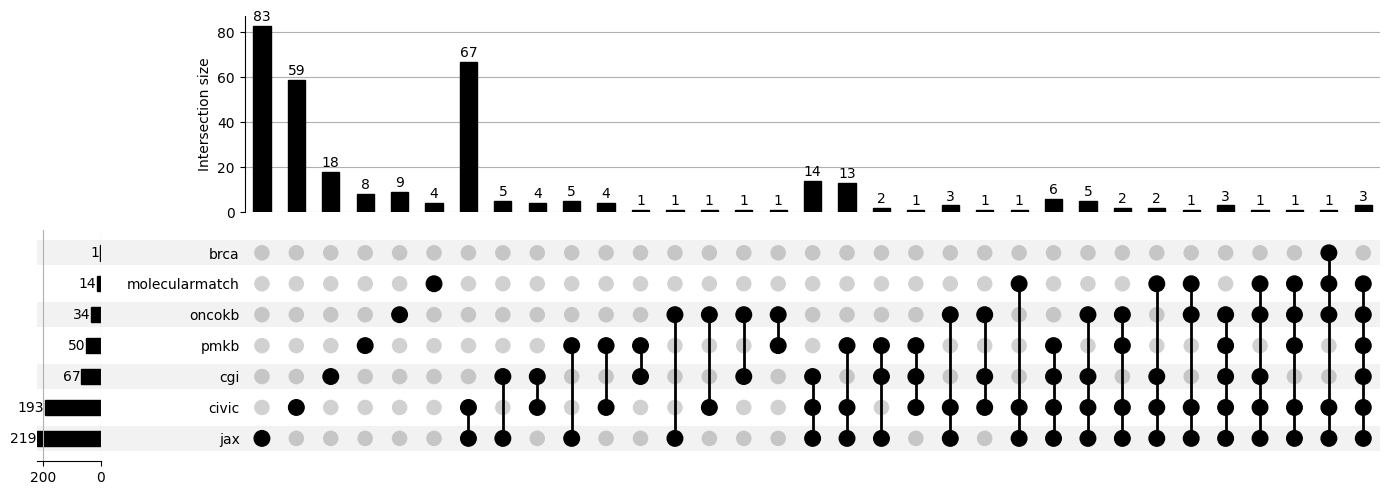

In [51]:
disease_uniqueness = calculate_uniqueness(disease_uniqueness,df,'disease_concept')
disease_proportions = disease_uniqueness # Copy of the DF for later
upset_data = format_for_upset(disease_uniqueness,'disease_concept')
plot(upset_data, show_counts=True)
plt.savefig('disease_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

### Therapeutics

In [52]:
therapy_uniqueness = pd.DataFrame({'therapy_concepts': unique_therapy_concepts,
                                'brca': None,
                                'cgi': None,
                                'civic': None,
                                'jax': None,
                                'molecularmatch': None,
                                'oncokb': None,
                                'pmkb': None})
therapy_uniqueness

,therapy_concepts,brca,cgi,civic,jax,molecularmatch,oncokb,pmkb
0,No Match,None,None,None,None,None,None,None
1,normalize.therapy.rxcui:662281,None,None,None,None,None,None,None
2,normalize.therapy.rxcui:1546019,None,None,None,None,None,None,None
3,normalize.therapy.rxcui:282388,None,None,None,None,None,None,None
4,normalize.therapy.rxcui:1314319,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
504,normalize.therapy.ncit:C77887,None,None,None,None,None,None,None
505,normalize.therapy.ncit:C99903,None,None,None,None,None,None,None
506,normalize.therapy.ncit:C66212,None,None,None,None,None,None,None
507,normalize.therapy.ncit:C90532,None,None,None,None,None,None,None


509it [00:04, 105.57it/s]
/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/mjc014/.pyenv/versions/3.12.2/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

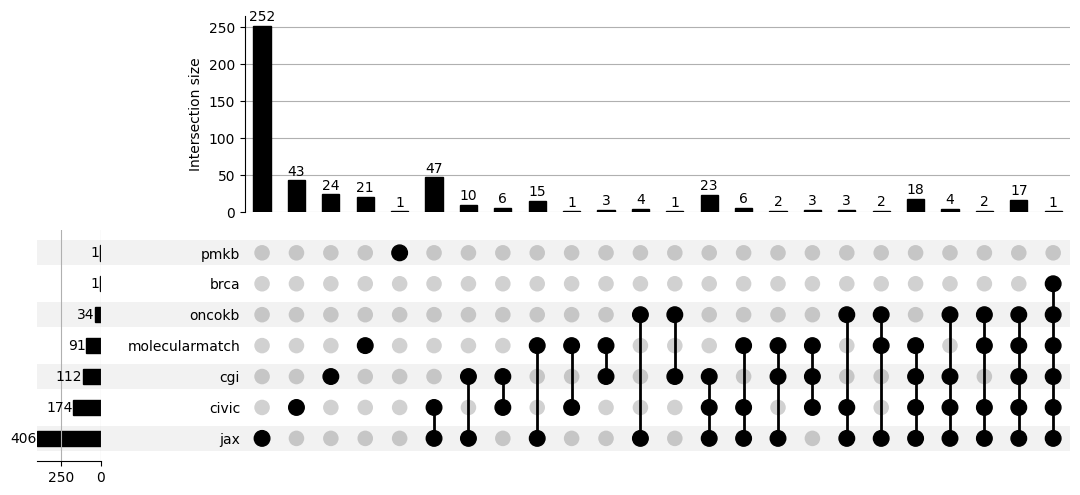

In [53]:
therapy_uniqueness = calculate_uniqueness(therapy_uniqueness,df,'therapy_concept')
therapy_proportions = therapy_uniqueness # Copy of the DF for later
upset_data = format_for_upset(therapy_uniqueness,'therapy_concept')
plot(upset_data, show_counts=True)
plt.savefig('therapy_unique_upset_plot.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

### Element Uniqueness

In [54]:
# Count number of sources True
gene_proportions["true_count"] = gene_proportions.iloc[:, 1:].sum(axis=1)
therapy_proportions["true_count"] = therapy_proportions.iloc[:, 1:].sum(axis=1)
disease_proportions["true_count"] = disease_proportions.iloc[:, 1:].sum(axis=1)

graph = pd.DataFrame({'# of KBs': [], 'Records': [], 'proportion': [], 'Record Type': []})

# Value Counts & Combine
tdf = gene_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Gene'
graph = pd.concat([graph,tdf])

tdf = therapy_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Therapy'
graph = pd.concat([graph,tdf])

tdf = disease_proportions['true_count'].value_counts().rename_axis('# of KBs').reset_index(name='Records')
total = tdf['Records'].sum()
tdf['proportion'] = tdf['Records'] / total
tdf['Record Type'] = 'Disease'
graph = pd.concat([graph,tdf])

# Plotly graph objects for the stacked bar
# fig = go.Figure()
colors = ['#fefadd','#def8d3','#a0e5e6','#48c1da','#1e97c7','#3459a9']

# Plotly graph objects for the stacked bar
fig = go.Figure()

# Adding each segment as part of a stacked bar
for i, row in graph.iterrows():
    fig.add_trace(go.Bar(
        name=f'{row["# of KBs"]} KBs',
        x=[row['Record Type']],  # single category for now
        y=[row['proportion']],
        marker_color=colors[i],  # using Plotly's qualitative colors
        width=[0.4]
    ))

# Update layout to show proportions as percentage
fig.update_layout(
    barmode='stack',
    title='Element uniqueness across KBs',
    xaxis_title='Category',
    yaxis_title='Proportion',
    yaxis=dict(tickformat=".2"),
    legend_title='# of KBs'
)

fig.show()

fig.write_image("v1_uniqueness.png", width=990, height=540, scale=3)